# FFS with Langevin Dynamics

### Define FFS Settings and Parameters

In [1]:
import numpy as np
import sys
import math
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
%matplotlib inline

#FFS settings
op_xtype = 1                 # order parameter x dependence. 1: linear 2: quadratic 3: cubic ...
op_ytype = 1                 # order parameter y dependence. 1: linear 2: quadratic 3: cubic ...
op_xcoef = [1]               # order parameter x coefficients. In ascending order [linear, quadratic, cubic, ...]
op_ycoef = [0]               # order parameter y coefficients. In ascending order [linear, quadratic, cubic, ...]
place = False                # apply interface placement algorithms?
if place:
    interfaces = []
    basinB = ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,2.0,2.0)
    print("Basin B is at {}".format(basinB))
    n_confs = 30             # number of collected configurations at interface 0
    explore_frac = 0.2       # fraction of trajectories to launch as exploring scouts
    p_des = 0.3              # desired crossing probability
    d_min = (basinB-ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,-2.0,-2.0))/50  # minimum interface displacement
else: 
    # default parameters for op=x and op=y
    interfaces = [-1.5, -1.4, -1.3, -1.2, -0.8, -0.5, 0.0, 1.0, 2.0] 
    basinA = -1.78           # boundary of basin A; must be less than first interface
    basinB = interfaces[-1]  # define basin B as the final interface
interface_trajs = 1000       # number of trajectories to launch from each interface
init_coords = [-1, -1]       # initial coordinates
init_p = [0, 0]              # initial momenta
basineqlen = 5000            # basin equilibration time (in steps)
basinlen = 50000             # basin simulation time
lag = 500
#Langevin dynamics settings
beta = 2.5      # 1/kT
gamma = 5       # friction coefficient
dt = 0.01       # time step size


### Plot Potential Energy Surface

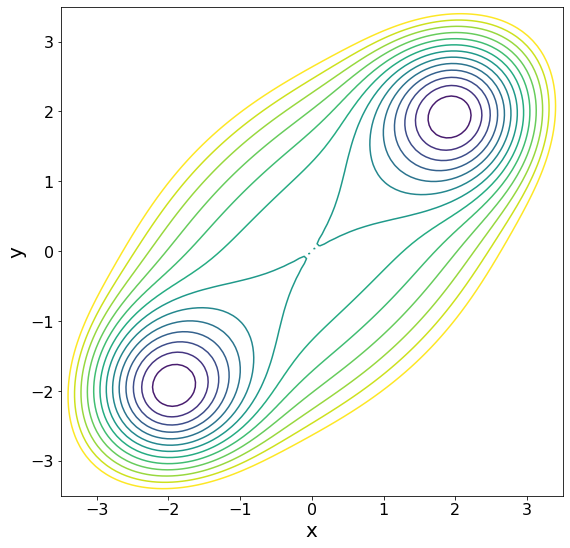

In [2]:
N = 100
x_vec = np.linspace(-3.5, 3.5, N)
y_vec = np.linspace(-3.5, 3.5, N)
pes_type = 1                       # 1: double well 2: double well w/ hump
well = 4                           # default: 4
energy = np.zeros((N, N))
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(pes_type,x_vec[i],y_vec[j],well=well)
fig, ax = plt.subplots(figsize=(9,9))
ax.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
ax.tick_params(axis='both',labelsize=16)
plt.show()

### Equilibrate the System

In [3]:
# declare array to store basin trajectory
basintraj = np.zeros((basinlen + 1, 6),dtype=float)
# calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma,pes_type,well)
# combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]
basintrajeq = ld.vv_step(init_phasepoint,dt,beta,gamma,pes_type,well)
# equilibrate in basin
for i in range(1,basineqlen + 1):
    new_basintrajeq = ld.vv_step(basintrajeq,dt,beta,gamma,pes_type,well)
    basintrajeq = new_basintrajeq
    op = ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,basintrajeq[0],basintrajeq[1])
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")


### Run Basin Simulation

Flux through first interface: 0.076

Number of first crossings: 38



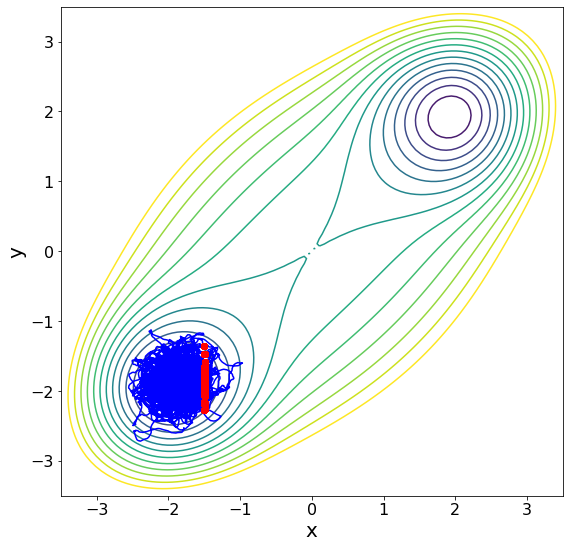

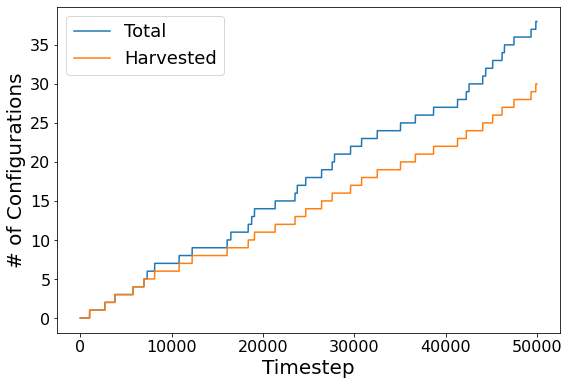

In [4]:
# start at final point of equilibration
basintraj[0] = basintrajeq
fromBasin = False
first_crosses = []
harvest_crosses = []
n_cross = 0
n_harvest = 0
cross_time = []
harvest_time = []
last = -lag
# run basin A simulation and check for first crossings
for j in range(1,basinlen + 1):
    basintraj[j] = ld.vv_step(basintraj[j-1],dt,beta,gamma,pes_type,well)
    op = ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,basintraj[j][0],basintraj[j][1])
    if not place:
        # collect first crossings
        if op < basinA:
            fromBasin = True
        if fromBasin == True and op >= interfaces[0]:
            first_crosses.append(basintraj[j])
            n_cross += 1
            if j - last > lag:
                harvest_crosses.append(basintraj[j])
                n_harvest += 1
                last = j
            fromBasin = False
        cross_time.append(n_cross)
        harvest_time.append(n_harvest)
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")
if place:
    lmda = [ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,basintraj[j][0],basintraj[j][1]) for j in range(len(basintraj))]
    avg = np.mean(lmda)
    stdev = np.std(lmda)
    # define basin A
    basinA = avg + 0.5*stdev
    print("Basin A is at {}\n".format(basinA))
    interfaces = [0]
    done = False
    # define l0 to satisfy desired harvested crossings
    for i in np.linspace(basinA,max(lmda),int(200*abs(basinA-max(lmda)))):
        n_cross = 0
        n_harvest = 0
        fromBasin = False
        last = -lag
        for j in range(len(lmda)):
            if lmda[j] < basinA:
                fromBasin = True
            if fromBasin == True and lmda[j] >= i:
                n_cross += 1
                fromBasin = False
                if j - last > lag:
                    n_harvest += 1
                    last = j
        if n_harvest >= n_confs:
            interfaces[0] = i
            done = True
    # exit if not enough crossings are harvested
    if not done:
        sys.exit("Not enough harvested crossings. Exiting...")
    print("Interface 0 is at {}\n".format(interfaces[0]))          
    # collect first crossings
    fromBasin = False
    n_cross = 0
    n_harvest = 0
    last = -lag
    for j in range(len(lmda)):
        if lmda[j] < basinA:
            fromBasin = True
        if fromBasin == True and lmda[j] >= interfaces[0]:
            first_crosses.append(basintraj[j])
            n_cross += 1
            if j - last > lag:
                harvest_crosses.append(basintraj[j])
                n_harvest += 1
                last = j
            fromBasin = False
        cross_time.append(n_cross)
        harvest_time.append(n_harvest)

# exit if there are no first crossings
if n_cross == 0:
    sys.exit("No first crossings obtained from basin A to interface 0. Exiting...")
flux = n_cross/(basinlen*dt)
print("Flux through first interface: {}\n".format(flux))
# evenly distribute configurations through simulations
print("Number of first crossings: {}\n".format(len(first_crosses)))
configs = []
for j in range(len(first_crosses)):
    for i in range(int(interface_trajs/len(first_crosses))):
        configs.append(first_crosses[j])
# randomly select the remainder without replacement
for i in np.asarray(random.sample(first_crosses,k=interface_trajs%len(first_crosses))):
    configs.append(i)
configs = np.asarray(configs)

x = [basintraj[j][0] for j in range(len(basintraj))]
y = [basintraj[j][1] for j in range(len(basintraj))]
# plot the configs selected for the first interface
fig, ax = plt.subplots(figsize=(9,9))
ax.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
ax.plot(x,y,color='b')
ax.plot(configs[:,0],configs[:,1],'ro')
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
ax.tick_params(axis='both',labelsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(cross_time,label="Total")
ax.plot(harvest_time,label="Harvested")
ax.set_xlabel('Timestep',fontsize=20)
ax.set_ylabel('# of Configurations',fontsize=20)
ax.tick_params(axis='both',labelsize=16)
ax.legend(fontsize=18)
plt.show()

### Interface Simulations

Starting interface 0...
Interface 1 first crossings from 0: 488
0 to 1 crossing prob: 0.488

Starting interface 1...
Interface 2 first crossings from 1: 472
1 to 2 crossing prob: 0.48360655737704916

Starting interface 2...
Interface 3 first crossings from 2: 460
2 to 3 crossing prob: 0.4872881355932203

Starting interface 3...
Interface 4 first crossings from 3: 49
3 to 4 crossing prob: 0.05326086956521739

Starting interface 4...
Interface 5 first crossings from 4: 237
4 to 5 crossing prob: 0.24183673469387756

Starting interface 5...
Interface 6 first crossings from 5: 273
5 to 6 crossing prob: 0.2879746835443038

Starting interface 6...
Interface 7 first crossings from 6: 309
6 to 7 crossing prob: 0.3772893772893773

Starting interface 7...
Interface 8 first crossings from 7: 809
7 to 8 crossing prob: 0.8727076591154261

Rate = 1.0674305555555555e-05


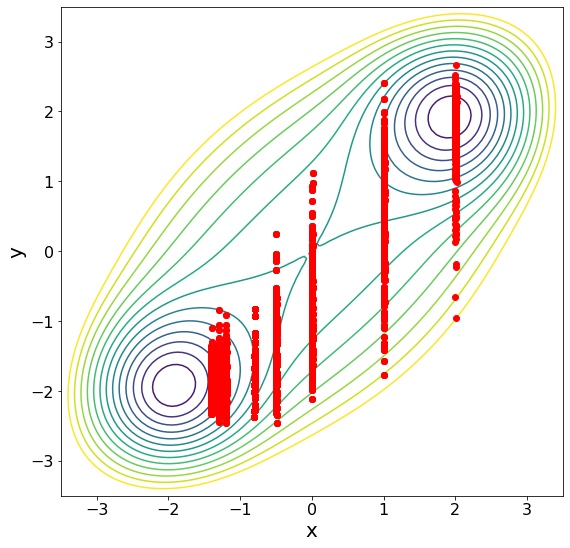

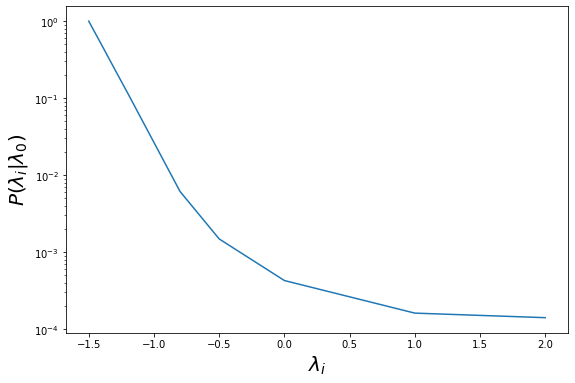

In [5]:
# run interfaces sequentially
fig, ax = plt.subplots(figsize=(9,9))
alltrajs = []
cross_probs = []
allyestrajs = []
allnotrajs = []
if not place:
    for i in range(len(interfaces) - 1):
        inttrajs = []
        yestrajs = []
        notrajs = []
        print("Starting interface {}...".format(i))
        first_crosses = []
        n_cross = 0
        for config in configs:
            op = ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,config[0],config[1])
            step = 0
            traj = []
            traj.append(config)
            while op >= basinA and op < interfaces[i+1]:
                traj.append(ld.vv_step(traj[step],dt,beta,gamma,pes_type,well))
                step += 1
                op = ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,traj[step][0],traj[step][1])
            if op >= interfaces[i+1]:
                n_cross += 1
                first_crosses.append(traj[step])
                yestrajs.append(np.asarray(traj))
            else:
                notrajs.append(np.asarray(traj))
            inttrajs.append(np.asarray(traj))
        if n_cross == 0:
            sys.exit("No first crossings obtained from interface {} to interface {}. Exiting...".format(i,i+1))
        cross_prob = n_cross/(len(inttrajs))
        cross_probs.append(cross_prob)
        alltrajs.append(inttrajs)
        allyestrajs.append(yestrajs)
        allnotrajs.append(notrajs)
        print("Interface {} first crossings from {}: {}".format(i+1,i,len(first_crosses)))
        print("{} to {} crossing prob: {}\n".format(i,i+1,cross_prob))
        configs = []
        for j in range(len(first_crosses)):
            for n in range(int(interface_trajs/len(first_crosses))):
                configs.append(first_crosses[j])
        configs = np.asarray(configs)
        np.append(configs,np.asarray(random.sample(first_crosses,k=interface_trajs%len(first_crosses))))
        ax.plot(configs[:,0],configs[:,1],'ro')
else:
    cnt = 0
    while interfaces[-1] < basinB:
        ##EXPLORING SCOUTS##
        print("Exploring from interface {}...".format(cnt))
        op_max = []
        for config in configs[::int(1/explore_frac)]:
            op = ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,config[0],config[1])
            op_maxi = op
            step = 0
            traj = []
            traj.append(config)
            while op >= basinA and op < basinB and step < 5000:
                traj.append(ld.vv_step(traj[step],dt,beta,gamma,pes_type,well))
                step += 1
                op = ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,traj[step][0],traj[step][1])
                if op > op_maxi:
                    op_maxi = op
            op_max.append(op_maxi)
        op_max.sort()
        if op_max[int((1-p_des)*len(op_max))] > basinB:
            interfaces.append(basinB)
        elif op_max[int((1-p_des)*len(op_max))]-interfaces[-1] < d_min:
            interfaces.append(interfaces[-1]+d_min)
        else:
            interfaces.append(op_max[int((1-p_des)*len(op_max))])
        print("Next interface is at {}\n".format(interfaces[-1]))
        inttrajs = []
        yestrajs = []
        notrajs = []
        ##INTERFACE SIMULATION##
        print("Starting interface {}...".format(cnt))
        first_crosses = []
        n_cross = 0
        for config in configs:
            op = ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,config[0],config[1])
            step = 0
            traj = []
            traj.append(config)
            while op >= basinA and op < interfaces[cnt+1]:
                traj.append(ld.vv_step(traj[step],dt,beta,gamma,pes_type,well))
                step += 1
                op = ld.calc_op(op_xtype,op_ytype,op_xcoef,op_ycoef,traj[step][0],traj[step][1])
            if op >= interfaces[cnt+1]:
                n_cross += 1
                first_crosses.append(traj[step])
                yestrajs.append(np.asarray(traj))
            else:
                notrajs.append(np.asarray(traj))
            inttrajs.append(np.asarray(traj))
        if n_cross == 0:
            sys.exit("No first crossings obtained from interface {} to interface {}. Exiting...".format(cnt,cnt+1))
        cross_prob = n_cross/(len(inttrajs))
        cross_probs.append(cross_prob)
        alltrajs.append(inttrajs)
        allyestrajs.append(yestrajs)
        allnotrajs.append(notrajs)
        print("Interface {} first crossings from {}: {}".format(cnt+1,cnt,len(first_crosses)))
        print("{} to {} crossing prob: {}\n\n".format(cnt,cnt+1,cross_prob))
        configs = []
        for j in range(len(first_crosses)):
            for n in range(int(interface_trajs/len(first_crosses))):
                configs.append(first_crosses[j])
        for c in np.asarray(random.sample(first_crosses,k=interface_trajs%len(first_crosses))):
            configs.append(c)
        configs = np.asarray(configs)
        ax.plot(configs[:,0],configs[:,1],'ro')
        cnt += 1
        

rate = flux*np.prod(np.asarray(cross_probs))
print("Rate = {}".format(rate))

# plot contour for collected configurations
ax.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
ax.tick_params(axis='both',labelsize=16)
plt.show()

# plot cumulative crossing probability
cumuprob = []
for i in range(0,len(cross_probs)+1):
    cumuprob.append(np.prod(np.asarray(cross_probs[:i])))
probs = plt.figure(2,figsize=(9,6))
plt.plot(interfaces,cumuprob)
plt.yscale('log')
plt.xlabel('$\lambda_i$',fontsize=20)
plt.ylabel('$P(\lambda_i|\lambda_0)$',fontsize=20)
ax.tick_params(axis='both',labelsize=16)
plt.show()

### Plot All Sampled Paths

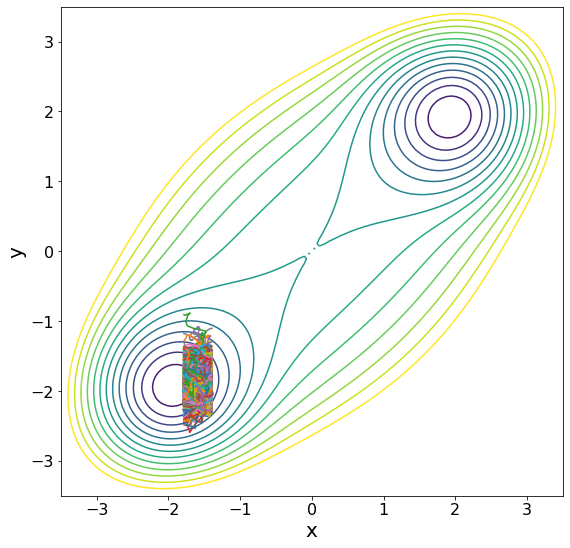

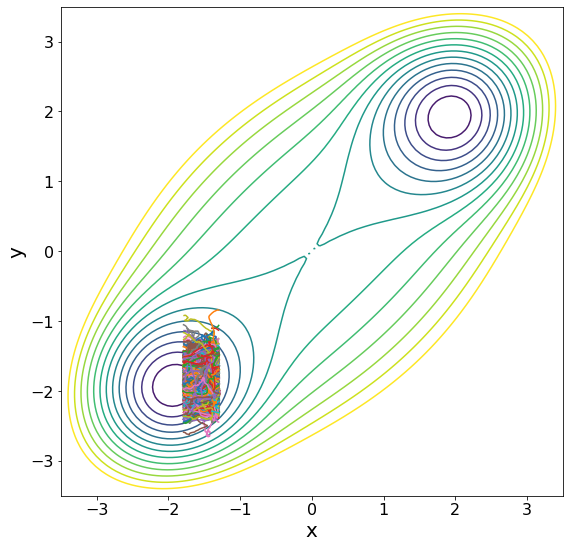

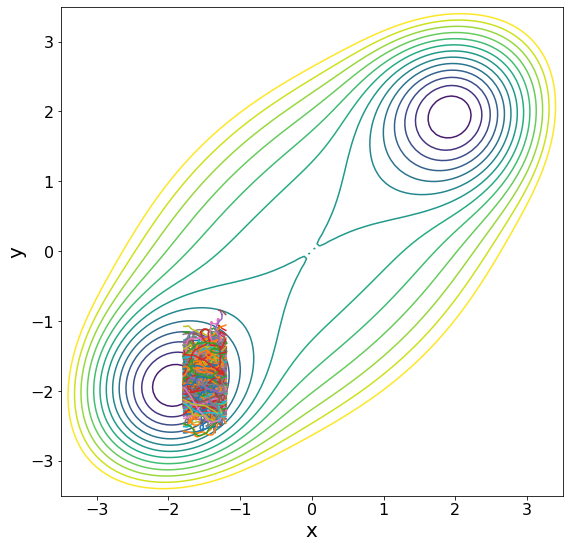

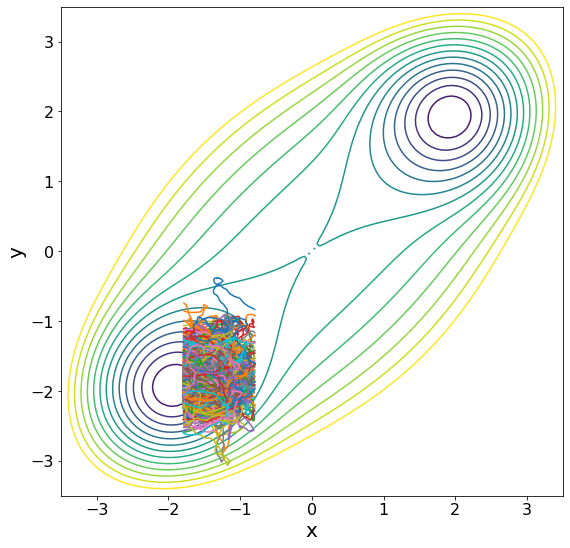

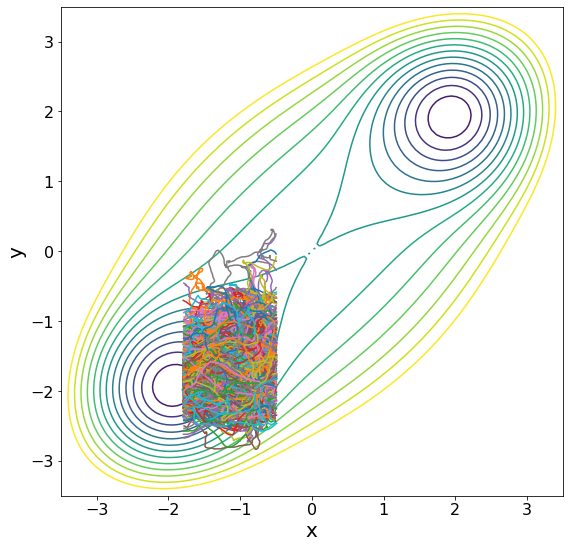

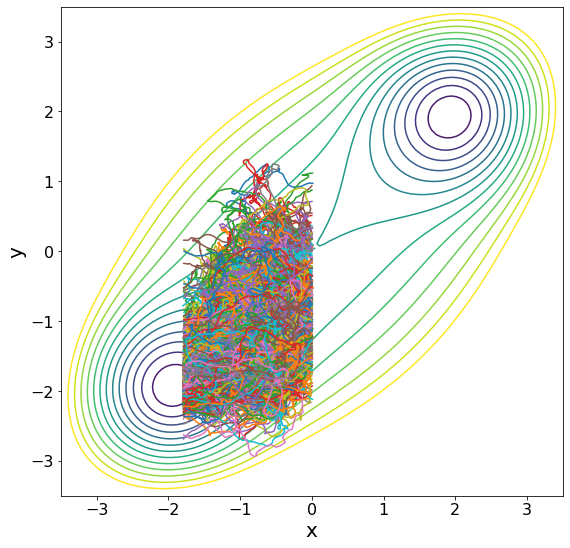

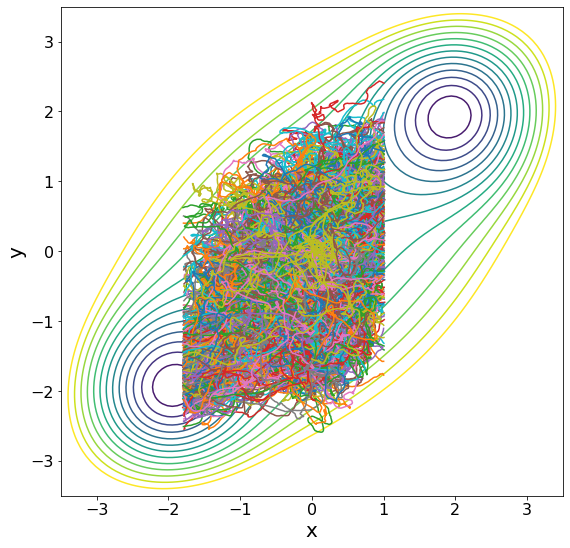

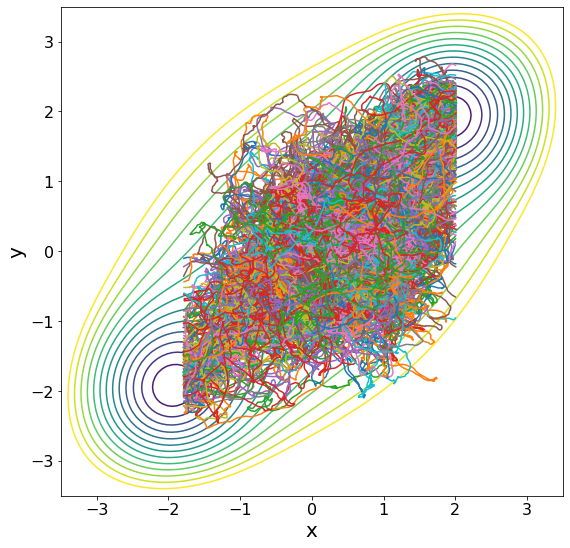

In [6]:
skip = 1
for i in range(len(interfaces) - 1):
    fig, ax = plt.subplots(figsize=(9,9))
    for j in range(len(alltrajs[i][::skip])):
        ax.plot(alltrajs[i][skip*j][:,0],alltrajs[i][skip*j][:,1])
    if op_xtype == 1 and op_ycoef == 0:
        ax.axvline(x=interfaces[i],color='k',alpha=0.5)
        ax.axvline(x=interfaces[i+1],color='k',alpha=0.5)
        ax.axvline(x=basinA,color='k',alpha=0.5)
    ax.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.tick_params(axis='both',labelsize=16)
    plt.show()

### Plot All Successful Paths

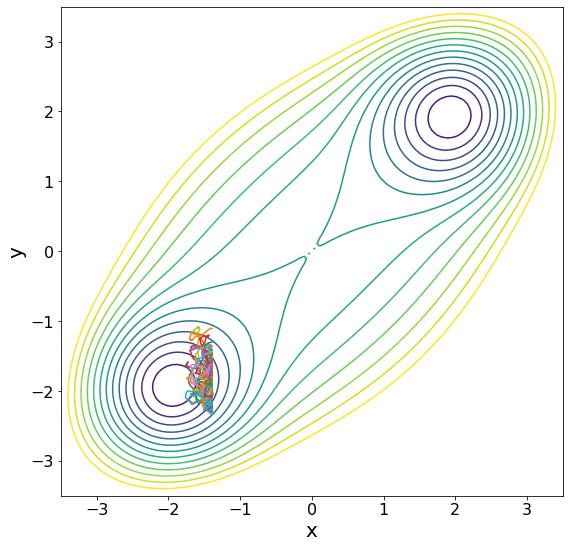

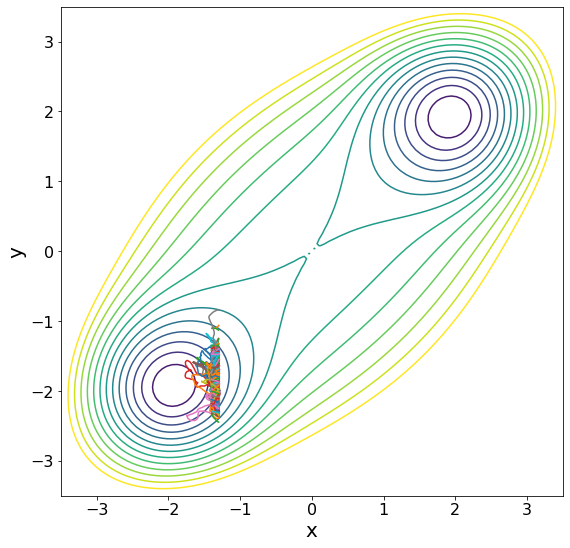

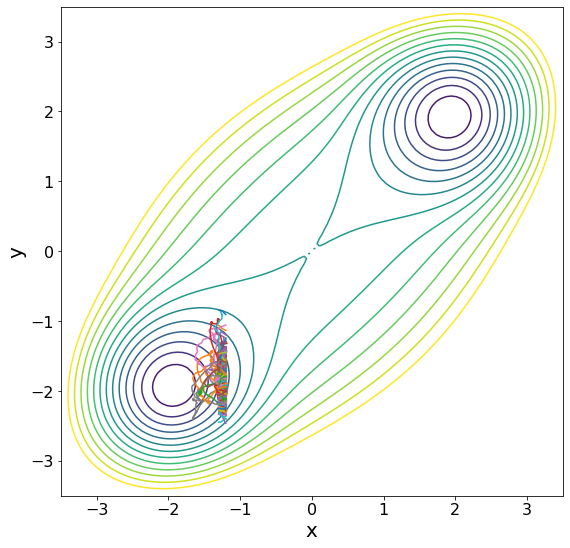

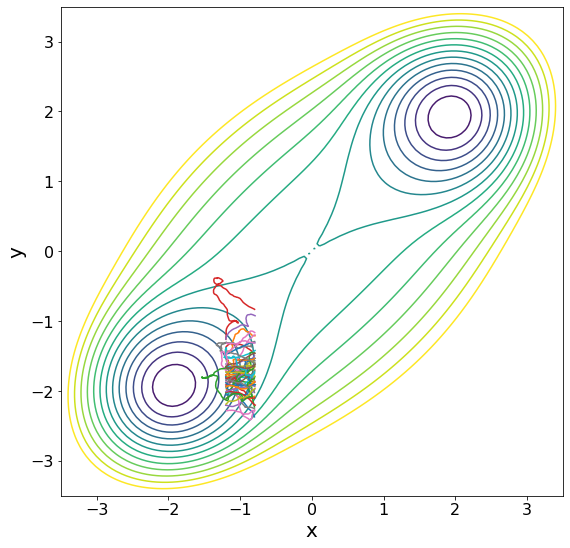

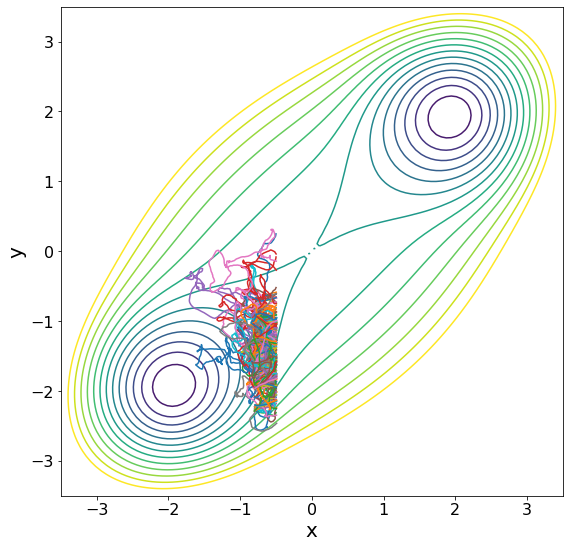

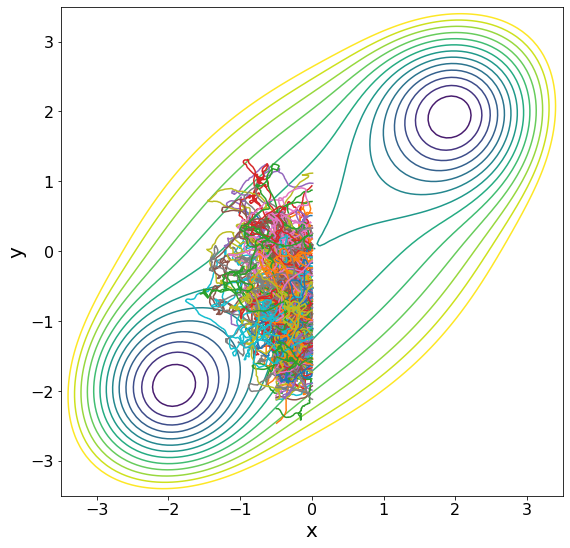

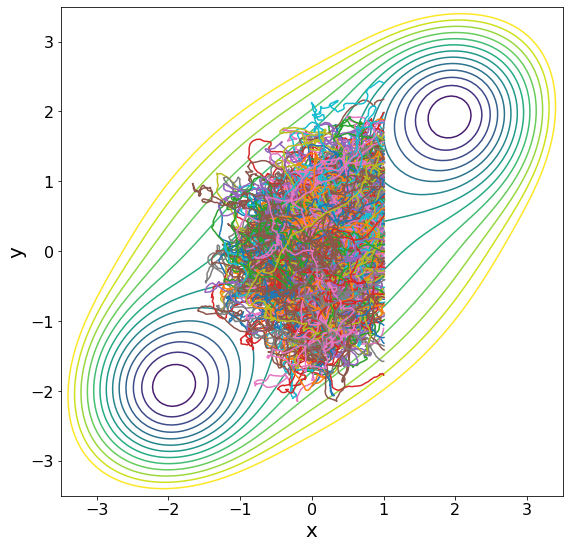

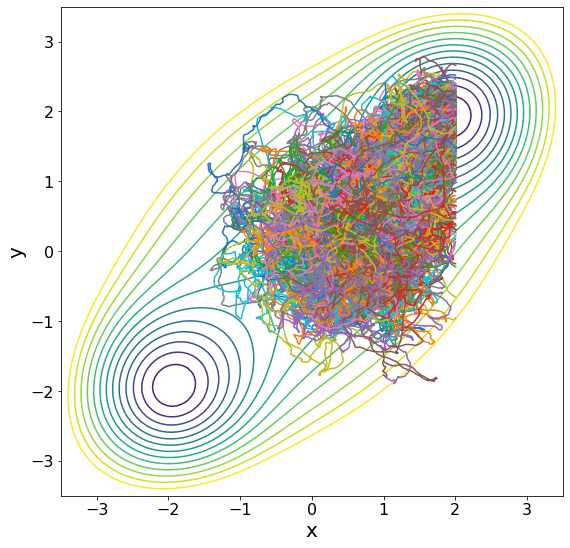

In [7]:
skip = 1
for i in range(len(interfaces) - 1):
    fig, ax = plt.subplots(figsize=(9,9))
    for j in range(len(allyestrajs[i][::skip])):
        ax.plot(allyestrajs[i][skip*j][:,0],allyestrajs[i][skip*j][:,1])
    if op_xtype == 1 and op_ycoef == 0:
        ax.axvline(x=interfaces[i],color='k',alpha=0.5)
        ax.axvline(x=interfaces[i+1],color='k',alpha=0.5)
        ax.axvline(x=basinA,color='k',alpha=0.5)
    ax.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.tick_params(axis='both',labelsize=16)
    plt.show()

### Plot All Unsuccessful Paths

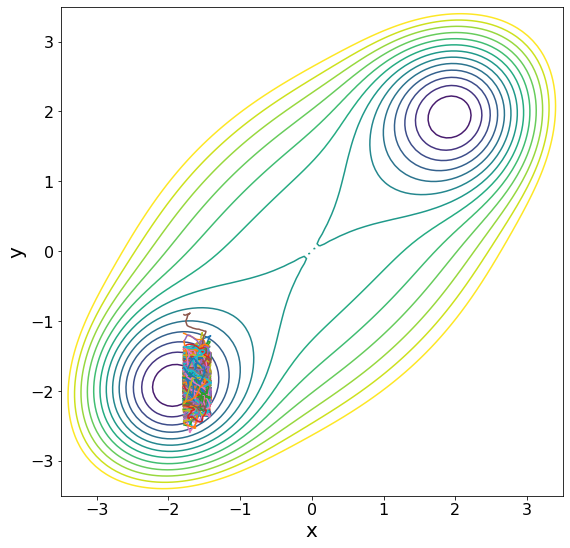

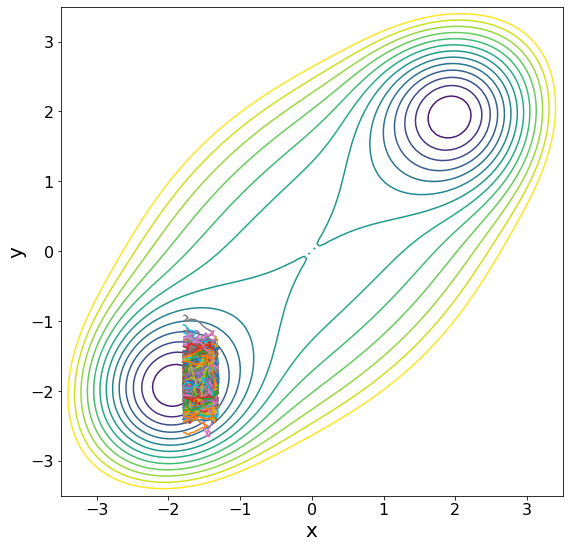

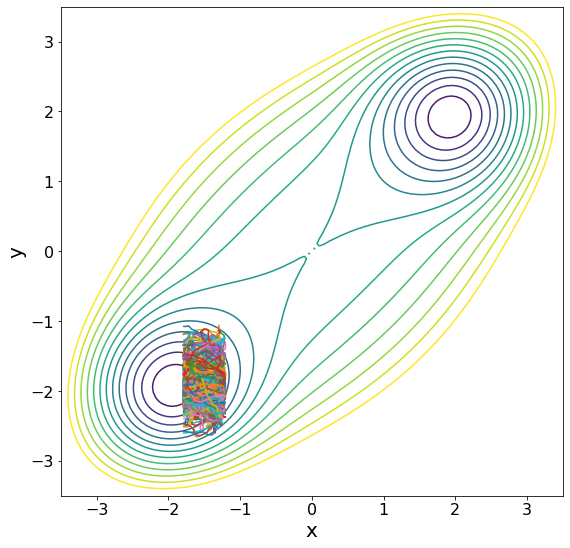

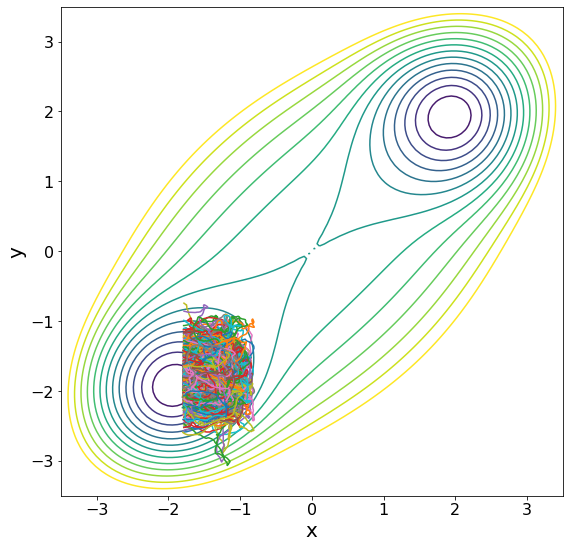

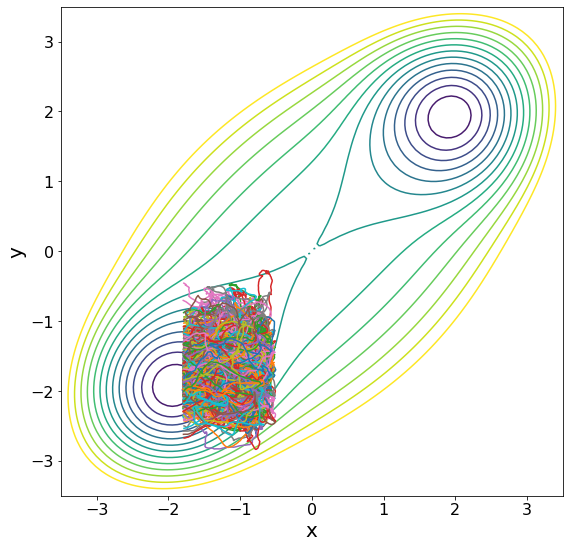

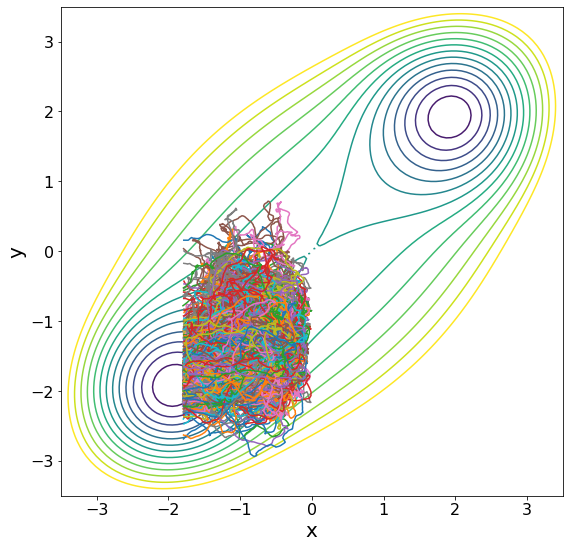

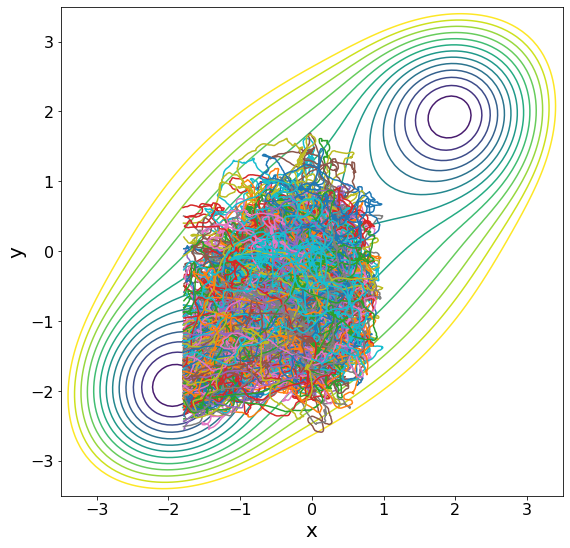

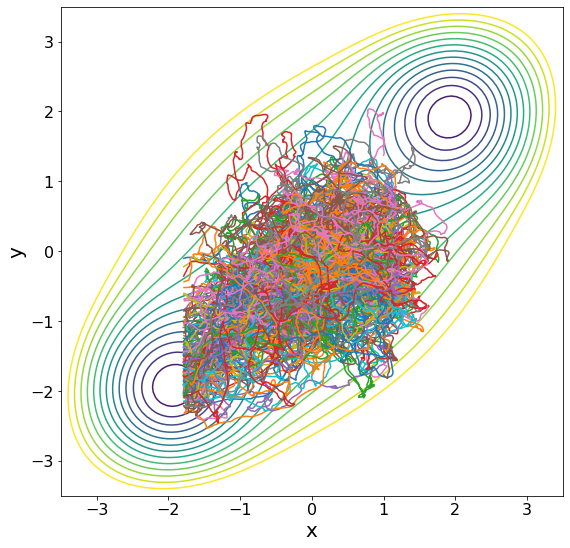

In [8]:
skip = 1
for i in range(len(interfaces) - 1):
    fig, ax = plt.subplots(figsize=(9,9))
    for j in range(len(allnotrajs[i][::skip])):
        ax.plot(allnotrajs[i][skip*j][:,0],allnotrajs[i][skip*j][:,1])
    if op_xtype == 1 and op_ycoef == 0:
        ax.axvline(x=interfaces[i],color='k',alpha=0.5)
        ax.axvline(x=interfaces[i+1],color='k',alpha=0.5)
        ax.axvline(x=basinA,color='k',alpha=0.5)
    ax.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.tick_params(axis='both',labelsize=16)
    plt.show()